In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms


import pandas as pd
import spacy

from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import time, math
%matplotlib inline

In [22]:
spacy_en = spacy.load('en')
model_path = 'models/splits.pth'
images_path = 'flickr/Images/'
df_path = 'data.csv'
test_df_path = 'test.csv'
test_examples_path = 'test_examples/'

In [3]:
class Vocabulary:
    def __init__(self, freq_threshold=2):
        self.freq_threshold = freq_threshold
        self.itos = {0:"<pad>", 1:"<sos>", 2:"<eos>", 3:"<unk>"}
        self.stoi = {"<pad>":0, "<sos>":1, "<eos>":2, "<unk>":3}
        
    def __len__(self):
        return len(self.itos)
    
    @staticmethod
    def tokenize_en(text):
        return [tok.text for tok in spacy_en.tokenizer(text.lower())]
    
    def build_vocabulary(self, sentence_list):
        freqs = {}
        idx = 4
        
        for sentence in sentence_list:
            for word in self.tokenize_en(sentence):
                if word not in freqs:
                    freqs[word] = 1
                else:
                    freqs[word] += 1

                if freqs[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenize_en(text)
        
        return [self.stoi[token] if token in self.stoi else self.stoi["<unk>"]
               for token in tokenized_text]
                

In [4]:
def build_vocab(data_file, freq_threshold=2 ,split='train'):
    df = pd.read_csv(data_file)
    df = df[df['split'] == split]
    captions = df.caption.values
    
    vocab = Vocabulary(freq_threshold)
    vocab.build_vocabulary(captions)
    
    return vocab

In [5]:
vocab = build_vocab(df_path)

In [6]:
pad_idx = vocab.stoi['<pad>']

### THe Model

In [7]:
# encoder CNN
class EncoderCNN(nn.Module):
    def __init__(self, hid_dim, dropout, train_cnn=False):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.train_cnn = train_cnn
        
        self.inception = models.inception_v3(pretrained=True, aux_logits=False)
        self.inception.fc = nn.Linear(self.inception.fc.in_features, hid_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, images):
        features = self.dropout(self.relu(self.inception(images)))
        return features
    

# decoder RNN
class DecoderRNN(nn.Module):
    def __init__(self, emb_dim, hid_dim, vocab_size, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim)
        self.linear = nn.Linear(hid_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, features, captions):
        embeddings = self.dropout(self.embedding(captions))
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        rnn_out, _ = self.rnn(embeddings)
        outputs = self.linear(rnn_out)
        return outputs

    
class Img2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert self.encoder.hid_dim == self.decoder.hid_dim
        
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

In [14]:
HID_DIM = 256
EMB_DIM = 256
DROPOUT = .5
VOCAB_LENGTH = len(vocab)
TRAIN_CNN = False
bs = 64
lr = 3e-3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder = EncoderCNN(HID_DIM, DROPOUT)
decoder = DecoderRNN(EMB_DIM, HID_DIM, VOCAB_LENGTH, DROPOUT)

model = Img2Seq(encoder, decoder, device).to(device)

In [9]:
device

device(type='cuda')

In [10]:
# transforms 
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [15]:
# load model
model = Img2Seq(encoder, decoder, device).to(device)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [16]:
def caption_image(image, model, max_len=50):
    
    model.eval()
    result_caption = []
    
    with torch.no_grad():
        context = model.encoder(image.to(model.device)).unsqueeze(0)
        #hidden = torch.tensor(vocab.stoi["<sos>"]).unsqueeze(0).to(model.device)
        states=None
        
        for t in range(1, max_len):
            output, states = model.decoder.rnn(context, states)
            output = model.decoder.linear(output.squeeze(0))
            top1 = output.argmax(1)
            context = model.decoder.embedding(top1).unsqueeze(0)
            
            result_caption.append(top1.item())
            if vocab.itos[top1.item()] == '<eos>':
                break
    return [vocab.itos[idx] for idx in result_caption]

In [17]:
def print_examples(model, csv_name, root_dir='test_examples'):
    df = pd.read_csv(csv_name)
    imgs = df['image'].tolist()
    captions = df['description'].tolist()
    i = 1
    for img_id, cap in zip(imgs, captions):
        img = Image.open(root_dir+img_id).convert("RGB")
        plt.imshow(img)
        plt.title(f'Example {i} Correct: {cap}')
        plt.axis('off')
        img = transform(img).unsqueeze(0)
        print(f"Output: {' '.join(caption_image(img, model)[1:-1])}")
        plt.show()
        i+=1

Output: a dog is running through the grass .


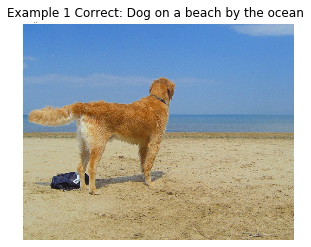

Output: a little girl in a pink dress is playing with a hula hoop .


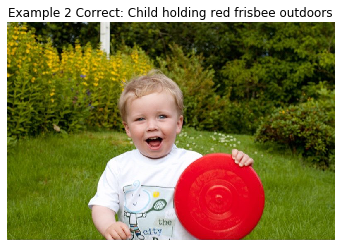

Output: a man in a red jacket is standing on a rock with a woman in a black jacket .


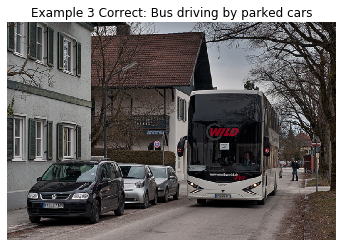

Output: a man in a blue shirt is standing on a rock overlooking a valley .


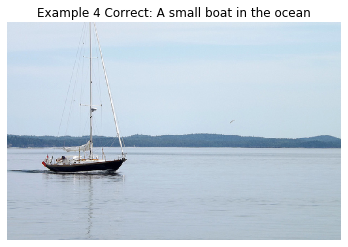

Output: a man in a red shirt is standing on a rock with a woman in a black jacket .


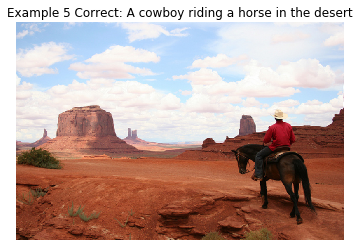

In [18]:
print_examples(model, csv_name=test_df_path, root_dir=test_examples_path)

In [31]:
from torchtext.data.metrics import bleu_score

def predict_test(test_dict, imgs_path, model, max_len=50, n_images=100):
    
    trgs = []
    pred_trgs = []
    
    i = 0
    
    for filename in test_dict:
        if i == n_images:break
        
        # getting the test image
        img = Image.open(imgs_path+'/'+filename).convert("RGB")
        img = transform(img).unsqueeze(0) # making it into a batch
        
        # making prediction
        pred = caption_image(img, model)
        
        if i % (n_images//10) == 0 and i!=0:
            print("prediction:", ' '.join(x for x in pred[1:-1]))
            print("actaul 1:", ' '.join(x for x in test_dict[filename][0]))
            
        
        pred_trgs.append(pred[:-1])
        trgs.append(test_dict[filename])
        
        i+=1
        
    return pred_trgs, trgs

In [29]:
# getting test data
df = pd.read_csv(df_path)
test_df = df[df['split'] == 'test']

img_ids = test_df.file_name.unique()

test_dict = {}
for img_id in img_ids:
    list_tokens = []
    for sent in test_df[test_df['file_name'] == img_id]['caption'].values:
        list_tokens.append(Vocabulary.tokenize_en(sent))
    
    test_dict[img_id] = list_tokens

In [32]:
preds, trgs = predict_test(test_dict, images_path, model, n_images=1000)

prediction: a black dog is running through the grass .
actaul 1: a group of dogs runs beside a pond through a field .
prediction: a man in a red shirt and a black jacket is standing next to a woman in a white shirt .
actaul 1: a girl wets her head in a white bucket .
prediction: a man in a red shirt and a woman in a white shirt and sunglasses .
actaul 1: a group of men wearing yellow shawls walk in a line .
prediction: a man in a red shirt is standing on a rock with a man in a black shirt .
actaul 1: a boy and a girl playing on the beach .
prediction: a man in a red shirt is standing in front of a large crowd of people .
actaul 1: children participate in a sport on a green field while in uniforms .
prediction: a black and white dog is running through the grass .
actaul 1: a boy wearing a teal shirt is riding a skateboard on a sidewalk .
prediction: a man in a blue shirt is surfing on a wave .
actaul 1: a boy jumping over another boy on a trampoline .
prediction: a young boy is playing 

In [36]:
len(preds), (len(trgs), len(trgs[0]))

(1000, (1000, 5))

In [44]:
def print_scores(preds, trgs):
    print("1:", bleu_score(preds, trgs, max_n=1, weights=[1])*100)
    print("2:", bleu_score(preds, trgs, max_n=2, weights=[.5, .5])*100)
    print("3:", bleu_score(preds, trgs, max_n=3, weights=[.33, .33, .33])*100)
    print("4:", bleu_score(preds, trgs)*100)

In [45]:
print_scores(preds, trgs)

1: 44.87767219543457
2: 26.120004057884216
3: 14.975661039352417
4: 8.615056425333023
